In [1]:
import torch
import platform
import numpy as np
import matplotlib.pyplot as plt


In [2]:
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"NumPy version: {np.__version__}")

# Test np availability to torch
try:
    torch_tensor = torch.from_np(np.array([1, 2, 3]))
    print(f"NumPy to PyTorch conversion: {torch_tensor}")
except Exception as e:
    print(f"NumPy-PyTorch integration error: {e}")

if torch.backends.mps.is_available():
    x = torch.randn(2, 2, device="mps")
    print(f"GPU test: {x.device}")
else:
    print("CPU only")


MPS available: True
NumPy version: 2.0.2
NumPy-PyTorch integration error: module 'torch' has no attribute 'from_np'
GPU test: mps:0


In [10]:
hidden_size = 45

def print_system_info():
    print(f"Platform: {platform.system()} {platform.machine()}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"MPS (Metal Performance Shaders) available: {torch.backends.mps.is_available()}")
    print(f"MPS built: {torch.backends.mps.is_built()}")

def get_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using device:", device)
    else:
        print("No GPU acceleration available - using CPU")
        device = torch.device("cpu")
    return device

def sample_data(n_samples, device, data_range=(0.0, 0.8)):
    # Sample only from [data_range[0], data_range[1]) for both x and y
    low, high = data_range
    X_np = np.random.rand(n_samples, 2) * (high - low) + low
    y_np = np.abs(X_np[:, 0] - X_np[:, 1])
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device).unsqueeze(1)
    return X, y

def make_model(device):
    model = torch.nn.Sequential(
        torch.nn.Linear(2, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, 1),
        torch.nn.Sigmoid(),
    ).to(device)
    return model

def ground_truth_heatmap(res=100):
    xx, yy = np.meshgrid(np.linspace(0,1,res), np.linspace(0,1,res))
    gt = np.abs(xx - yy)
    return gt

def plot_heatmap(ax, data, title):
    img = ax.imshow(data, origin='lower', extent=[0,1,0,1], vmin=0, vmax=1, cmap="viridis")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

def nn_output_heatmap(model, device, res=100):
    xx, yy = np.meshgrid(np.linspace(0,1,res), np.linspace(0,1,res))
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
    grid_torch = torch.tensor(grid, dtype=torch.float32, device=device)
    with torch.no_grad():
        preds = model(grid_torch).cpu().numpy().reshape(res, res)
    return preds

def plot_progress(models, device, titles):
    gt = ground_truth_heatmap()
    fig, axs = plt.subplots(len(models), 2, figsize=(10, 4*len(models)))
    if len(models) == 1:
        axs = np.expand_dims(axs, 0)
    for i, model in enumerate(models):
        preds = nn_output_heatmap(model, device)
        plot_heatmap(axs[i, 0], preds, titles[i])
        plot_heatmap(axs[i, 1], gt, "True Probability |x-y|")
    plt.suptitle("Prob(label=1 | x, y)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def compute_accuracy(outputs, targets, tol=0.05):
    # For regression, we'll treat as correct if prediction is within tol of true.
    pred = outputs.squeeze().detach().cpu().numpy()
    true = targets.squeeze().detach().cpu().numpy() if targets.requires_grad else targets.squeeze().cpu().numpy()
    correct = (np.abs(pred - true) < tol)
    accuracy = np.mean(correct)
    return accuracy

def train_and_snapshot(model, 
                       X_train, y_train, 
                       X_val, y_val, 
                       optimizer, criterion, device, 
                       num_epochs, snapshot_epochs):
    models_snapshots = []
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    snapshot_set = set(snapshot_epochs)
    for epoch in range(num_epochs+1):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_acc = compute_accuracy(outputs, y_train)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
            val_acc = compute_accuracy(val_outputs, y_val)
            val_accuracies.append(val_acc)

        if epoch in snapshot_set:
            # Deepcopy model weights for snapshotting
            snapshot = torch.nn.Sequential(
                torch.nn.Linear(2, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, 1),
                torch.nn.Sigmoid(),
            ).to(device)
            snapshot.load_state_dict(model.state_dict())
            models_snapshots.append(snapshot)
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return models_snapshots, train_losses, val_losses, train_accuracies, val_accuracies, snapshot_epochs

def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label="Train")
    plt.plot(val_accuracies, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (reg. tol 0.05)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

def main():
    print_system_info()
    device = get_device()
    N = 2048

    # Train data: [0, 0.8)
    X_train, y_train = sample_data(N, device, data_range=(0.0, 0.8))
    # Val data: [0.8, 1)
    X_val, y_val = sample_data(N//2, device, data_range=(0.8, 1.0))

    model = make_model(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

    num_epochs = 3000
    snapshot_epochs = [0, 10, 30, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000]
    titles = [f"NN Output (Epoch {ep})" for ep in snapshot_epochs]

    models_snapshots, train_losses, val_losses, train_accuracies, val_accuracies, snapshot_epochs = train_and_snapshot(
        model, 
        X_train, y_train, 
        X_val, y_val, 
        optimizer, criterion, device,
        num_epochs=num_epochs,
        snapshot_epochs=snapshot_epochs
    )

    plot_progress(models_snapshots, device, titles)
    plot_loss(train_losses, val_losses)
    plot_accuracy(train_accuracies, val_accuracies)

Platform: Darwin arm64
PyTorch version: 2.8.0
MPS (Metal Performance Shaders) available: True
MPS built: True
Using device: mps
Epoch 0, Loss: 0.6388, Val Loss: 0.4364, Train Acc: 0.1211, Val Acc: 0.0000
Epoch 10, Loss: 0.5721, Val Loss: 0.3494, Train Acc: 0.1685, Val Acc: 0.0078
Epoch 30, Loss: 0.5406, Val Loss: 0.2651, Train Acc: 0.2319, Val Acc: 0.3799
Epoch 50, Loss: 0.5050, Val Loss: 0.2501, Train Acc: 0.3770, Val Acc: 0.7148
Epoch 100, Loss: 0.4827, Val Loss: 0.2418, Train Acc: 0.9355, Val Acc: 0.7822
Epoch 200, Loss: 0.4819, Val Loss: 0.2452, Train Acc: 0.9429, Val Acc: 0.7227
Epoch 500, Loss: 0.4792, Val Loss: 0.2441, Train Acc: 1.0000, Val Acc: 0.7100
Epoch 1000, Loss: 0.4786, Val Loss: 0.2393, Train Acc: 1.0000, Val Acc: 0.7998
Epoch 1500, Loss: 0.4783, Val Loss: 0.2351, Train Acc: 1.0000, Val Acc: 0.9219
Epoch 2000, Loss: 0.4784, Val Loss: 0.2332, Train Acc: 1.0000, Val Acc: 0.9609
Epoch 2500, Loss: 0.4782, Val Loss: 0.2333, Train Acc: 1.0000, Val Acc: 0.9395
Epoch 3000, Los

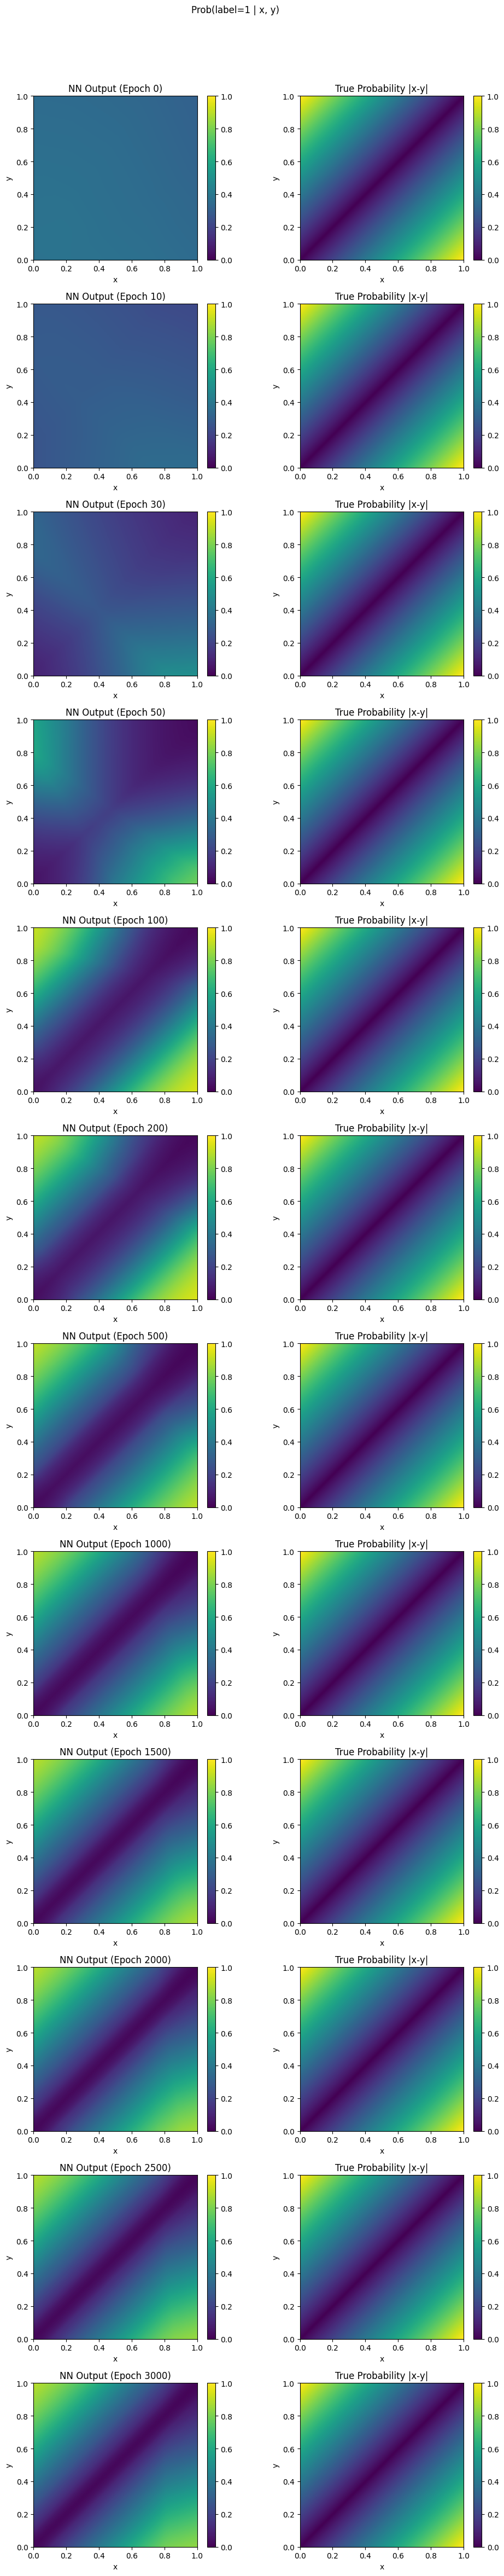

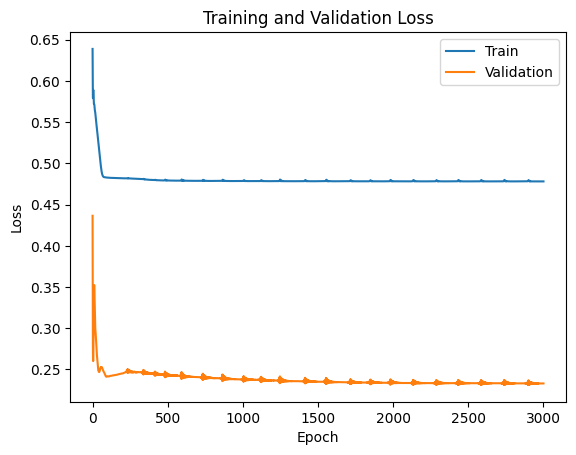

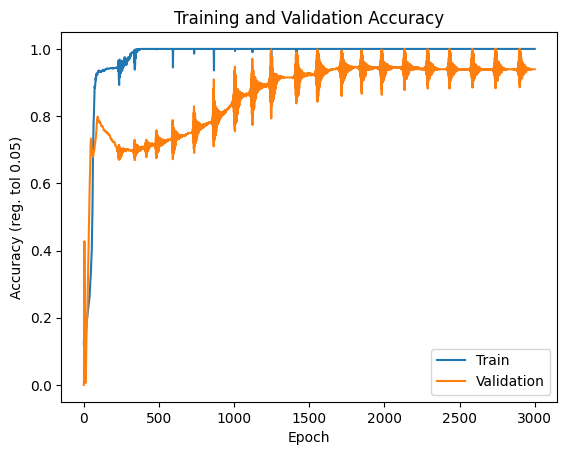

In [11]:
main()
